In [1]:
# ==============================================================================
# Imports
# ==============================================================================

# This is needed so that python finds the utils
import sys
sys.path.append("/home/gf332/miracle-compession/code")

import matplotlib.pyplot as plt
import numpy as np

from imageio import imwrite

import argparse
import os, glob
import json
from tqdm import tqdm

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

tfe = tf.contrib.eager
tfs = tf.contrib.summary
tfs_logger = tfs.record_summaries_every_n_global_steps

from architectures import ClicCNN, ClicHyperVAECNN, ClicLadderCNN
from experiment import clic_input_fn
from utils import is_valid_file, setup_eager_checkpoints_and_restore
from load_data import load_and_process_image, create_random_crops, download_process_and_load_data

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# ==============================================================================
# Predefined Stuff
# ==============================================================================

models = {
    "cnn": ClicCNN,
    "hyper_cnn": ClicHyperVAECNN,
    "ladder_cnn": ClicLadderCNN
}


optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=False),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

In [3]:
!ls /home/gf332/miracle-models

hyper_cnn_gauss_gauss_prior  hyper_cnn_laplace


In [4]:
model_key="hyper_cnn"
model_dir="/home/gf332/miracle-models/hyper_cnn_gauss_gauss_prior"
is_training=False

# ==========================================================================
# Configuration
# ==========================================================================

config = {
        "training_set_size": 93085,
        "pixels_per_training_image": 256 * 256 * 3,
        
        # When using VALID for the hierarchical VAEs, this will give the correct
        # latent size
        "image_size": [256, 256],

        "batch_size": 8,
        "num_epochs": 20,
        
        "first_level_channels": 192,
        "second_level_channels": 128,
        "first_level_layers": 4,

        "loss": "nll_perceptual_kl",
        "likelihood": "gaussian",
        "prior": "gaussian",
        
        # % of the number of batches when the coefficient is capped out 
        # (i.e. for 1., the coef caps after the first epoch exactly)
        "warmup": 2., 
        "beta": 0.1,
        "gamma": 0.,
        "learning_rate": 3e-5,
        "optimizer": "adam",

        "log_freq": 50,
        "checkpoint_name": "_ckpt",
    }

# ==========================================================================
# Create VAE model
# ==========================================================================

with tf.device("CPU:0"):
    model = models[model_key]

    if model_key == "cnn":
        vae = model(prior=config["prior"],
                    likelihood=config["likelihood"],
                    padding="SAME_MIRRORED")
        
    elif model_key in ["hyper_cnn", "ladder_cnn"]:
        vae = model(latent_dist=config["prior"],
                    likelihood=config["likelihood"],
                    first_level_channels=config["first_level_channels"],
                    second_level_channels=config["second_level_channels"],
                    first_level_layers=config["first_level_layers"],
                    padding_first_level="SAME_MIRRORED",
                    padding_second_level="SAME_MIRRORED")

    # Connect the model computational graph by executing a forward-pass
    vae(tf.zeros((1, 256, 256, 3)))

    optimizer = optimizers[config["optimizer"]](config["learning_rate"])

    # ==========================================================================
    # Define Checkpoints
    # ==========================================================================

    global_step = tf.train.get_or_create_global_step()

    trainable_vars = vae.get_all_variables() + (global_step,)
    checkpoint_dir = os.path.join(model_dir, "checkpoints")

    checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
        variables=trainable_vars,
        checkpoint_dir=checkpoint_dir,
        checkpoint_name=config["checkpoint_name"])

Instructions for updating:
Colocations handled automatically by placer.
Checkpoint found at /home/gf332/miracle-models/hyper_cnn_gauss_gauss_prior/checkpoints/_ckpt-17, restoring...
Model restored!


In [5]:
train_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/train/"
valid_image_dir = "/home/gf332/.keras/datasets/miracle_image_compression/valid"

train_image_paths = glob.glob(train_image_dir + "/*.png")
valid_image_paths = glob.glob(valid_image_dir + "/*.png")

with tf.device("CPU:0"):
    
    train_img_1 = load_and_process_image(valid_image_paths[0])
    encoded_1 = vae(tf.convert_to_tensor(train_img_1[None, ...]))
    
    encoded_1 = tf.clip_by_value(encoded_1, 0., 1.)
    ms_ssim = tf.image.ssim_multiscale(tf.convert_to_tensor(train_img_1), encoded_1, 1.)
    
    print("MS-SSIM: {:.4f}".format(ms_ssim.numpy()[0]))
    
    print("KL divergence (log2): {:.2f}".format(vae.kl_divergence.numpy() / np.log(2)))
    print("Last KL (log2): {:.2f}".format(tf.reduce_sum(tfd.kl_divergence(vae._latent_posteriors[0], vae._latent_priors[0]))  / np.log(2)))

MS-SSIM: 0.8815
KL divergence (log2): 36358.03
Last KL (log2): 30056.84


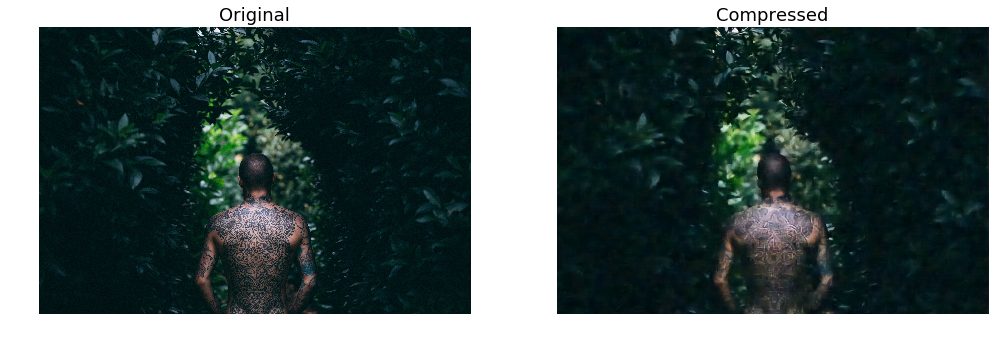

In [6]:
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.imshow(train_img_1)
plt.title("Original", fontsize=18)
plt.axis("off")

plt.subplot(122)
plt.title("Compressed", fontsize=18)
plt.imshow(tf.squeeze(encoded_1).numpy())
plt.axis("off")

plt.show()

In [7]:
from imageio import imwrite

clipped = np.squeeze(encoded_1.numpy())
clipped[clipped > 1] = 1
clipped[clipped < 0] = 0

clipped *= 255

clipped = clipped.astype(np.uint8)

im_path = "/home/gf332/miracle-compession/img/clic/gauss_gauss2.png"

if not os.path.exists(im_path):
    imwrite(im_path, clipped)
else:
    print("{} already exists".format(im_path))

In [ ]:
# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
import numpy as np
from scipy.stats import norm

# use 4 blocks

block_limit = 15
block_size = 5
num_blocks = 8

In [ ]:
def compress(latent, prior, posterior, block_limit=15, block_size=5, skip=50):
    
    uniform_approx_samp_block = i4_sobol_generate(block_size, np.power(2, block_limit), skip=skip)
    normal_approx_samp_block = norm.ppf(uniform_approx_samp_block)

    latent_size = tuple(latent.shape.as_list())
    total_length = tf.prod(latent_size)
    
    # Turn image into vector
    latent = tf.reshape(latent, [-1])
    
    for i in range(total_length):
        

In [12]:
!ls /home/gf332/.keras/datasets/miracle_image_compression

__MACOSX  train  train_processed  train.zip  valid  valid.zip


In [24]:
!ls ../..

clic_processed_dataset_360x360.tar.gz  gpu_requirements.txt  README.md
clic_processed_dataset.tar.gz	       img		     requirements.txt
code				       LICENSE		     thesis
config				       miracle_venv	     thesis.org
gpu_miracle_venv		       papers		     v


In [19]:
!sudo apt-get --assume-yes install imagemagick

E: Could not get lock /var/lib/dpkg/lock-frontend - open (11: Resource temporarily unavailable)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), is another process using it?


In [22]:
!file /home/gf332/.keras/datasets/miracle_image_compression/train_processed/0_0.png

/home/gf332/.keras/datasets/miracle_image_compression/train_processed/0_0.png: PNG image data, 360 x 360, 8-bit/color RGB, non-interlaced
